In [ ]:
!gdown --id 0B7XkCwpI5KDYNlNUTTlSS21pQmM

Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /content/GoogleNews-vectors-negative300.bin.gz
1.65GB [00:08, 195MB/s]


In [ ]:
!gdown --id 1TLNXKvF52x3rEemhFXCRSV0OPGbsj-Le

Downloading...
From: https://drive.google.com/uc?id=1TLNXKvF52x3rEemhFXCRSV0OPGbsj-Le
To: /content/GoogleNews-vectors-negative300.bin.gz
1.65GB [00:35, 46.2MB/s]


In [ ]:
a = ['asdkfopaskdflkjasldfkaksdlfkl;askdfl;ksad']
while True:
  a *= 1000

In [ ]:
%tensorflow_version 1.x

import numpy as np
import pandas as pd
from numpy.linalg import norm
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import Image, display_png
from gensim.models import word2vec, KeyedVectors
from keras.models import Sequential
from keras.layers import Input, Embedding, Dense, Dropout, Flatten, GlobalAveragePooling1D, LSTM
from keras.utils import to_categorical, plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Using TensorFlow backend.


In [ ]:
data = pd.read_csv('lab4_train.csv') 
train, dev = np.split(data, [int(len(data)*0.8)])

In [ ]:
!gunzip --keep /content/GoogleNews-vectors-negative300.bin.gz

In [ ]:
!ls

GoogleNews-vectors-negative300.bin     lab4_train.csv
GoogleNews-vectors-negative300.bin.gz  sample_data


In [ ]:
from gensim.models import word2vec, KeyedVectors
google_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
vocab_size = len(google_model.vocab)
vector_dim = len(google_model['home'])
max_len = 70

In [ ]:
# word to index dictionary, 0 for padding, UNKNOWN
word_to_index = {'PADDING':0}

# make weight matrix of word embedding, vocab size + 1 (for padding)
embedding_matrix = np.zeros((vocab_size+1, vector_dim), dtype="float32")
embedding_matrix[0] = np.zeros(vector_dim)

for i, word in enumerate(google_model.vocab):
    word_to_index[word] = i+1
    embedding_matrix[i+1] = google_model[word] 

In [ ]:
word_to_index['home']

125

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk import word_tokenize
train['tokenized'] = train['text'].apply(word_tokenize)
dev['tokenized'] = dev['text'].apply(word_tokenize)

In [ ]:
# convert word to index (maximum: first 500 words)
def w2i(tokens):
    return [word_to_index.get(word, 0) for word in tokens[:max_len]]

# apply functions & convert to np.array
input_train = np.array(train['tokenized'].apply(w2i).tolist())
input_dev = np.array(dev['tokenized'].apply(w2i).tolist())

# input : zero padding
train_x = pad_sequences(input_train, max_len, padding='post')
dev_x = pad_sequences(input_dev, max_len, padding='post')

In [ ]:
def relabel(aspect):
  categories = list(train['aspectCategory'].unique())
  return categories.index(aspect)

# apply functions & convert to np.array
label_train = np.array(train['aspectCategory'].apply(relabel).tolist())
label_dev = np.array(dev['aspectCategory'].apply(relabel).tolist())

# label : one-hot vector
train_y = to_categorical(label_train, num_classes=5)
dev_y = to_categorical(label_dev, num_classes=5)

In [ ]:
# check the shape
print('input train:', train_x.shape)
print('input dev:', dev_x.shape)
print('label train:', train_y.shape)
print('label dev:',dev_y.shape)

input train: (2524, 70)
input dev: (632, 70)
label train: (2524, 5)
label dev: (632, 5)


In [ ]:
# instantiation
model = Sequential()

# add embedding layer
model.add(Embedding(input_dim=vocab_size+1,
                    input_length=max_len,
                    output_dim=vector_dim, 
                    weights=[embedding_matrix], 
                    mask_zero=True,
                    trainable=False))

# average
model.add(LSTM(200))

# add hidden layer
model.add(Dense(150, activation='relu'))


# add output layer
model.add(Dense(5, activation='softmax'))

# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 300)           900000300 
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dense_3 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 755       
Total params: 900,432,005
Trainable params: 431,705
Non-trainable params: 900,000,300
_________________________________________________________________


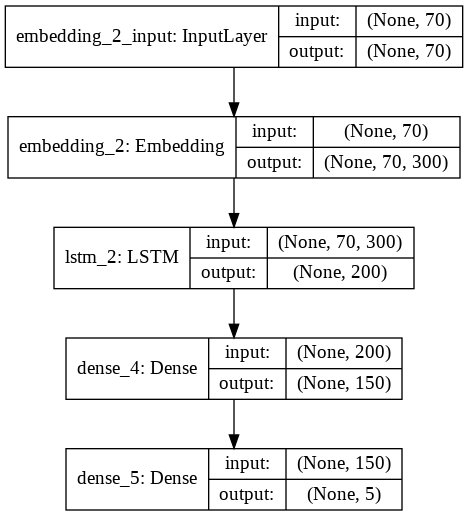

In [ ]:
plot_model(model, show_shapes=True,to_file='model.png')
display_png(Image('model.png'))

In [ ]:
train_x

array([[   85,    12,   555, ...,     0,     0,     0],
       [  383,    17,  1882, ...,     0,     0,     0],
       [  383,    17,  1882, ...,     0,     0,     0],
       ...,
       [   21,    22, 11813, ...,     0,     0,     0],
       [   63,    38,  3050, ...,     0,     0,     0],
       [65089,  3447,   561, ...,     0,     0,     0]], dtype=int32)

In [ ]:
train_y

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
# train
history = model.fit(train_x, train_y, batch_size=8, epochs=20, validation_data=(dev_x, dev_y))

Train on 2524 samples, validate on 632 samples
Epoch 1/20
2524/2524 [==============================] - 30s 12ms/step - loss: 4.8147 - acc: 0.4742 - val_loss: 3.5333 - val_acc: 0.5174
Epoch 2/20
2524/2524 [==============================] - 29s 11ms/step - loss: 3.5146 - acc: 0.4853 - val_loss: 3.5139 - val_acc: 0.5427
Epoch 3/20
2524/2524 [==============================] - 29s 11ms/step - loss: 2.2132 - acc: 0.5214 - val_loss: 1.3572 - val_acc: 0.5222
Epoch 4/20
2524/2524 [==============================] - 29s 11ms/step - loss: 1.2434 - acc: 0.5567 - val_loss: 1.4087 - val_acc: 0.5174
Epoch 5/20
2524/2524 [==============================] - 29s 11ms/step - loss: 1.3372 - acc: 0.5622 - val_loss: 1.4701 - val_acc: 0.4241
Epoch 6/20
2524/2524 [==============================] - 28s 11ms/step - loss: 1.2458 - acc: 0.5551 - val_loss: 1.1606 - val_acc: 0.6092
Epoch 7/20
2524/2524 [==============================] - 29s 11ms/step - loss: 1.2669 - acc: 0.6300 - val_loss: 1.6824 - val_acc: 0.6408
E

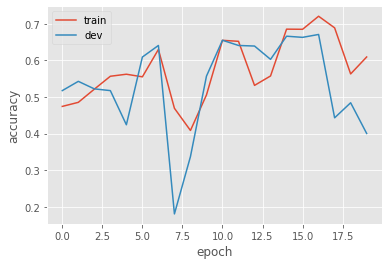

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

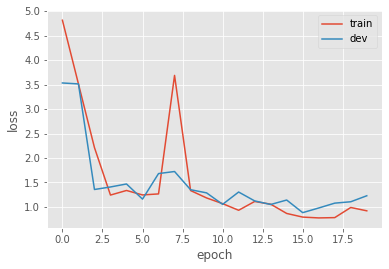

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='best')
plt.show()

In [ ]:
prediction = [np.argmax(x) for x in model.predict(dev_x)]
print(classification_report(label_dev, prediction))

              precision    recall  f1-score   support

           0       1.00      0.03      0.06       104
           1       0.79      0.47      0.59       203
           2       0.89      0.45      0.60       194
           3       1.00      0.02      0.03        60
           4       0.16      0.94      0.28        71

    accuracy                           0.40       632
   macro avg       0.77      0.38      0.31       632
weighted avg       0.80      0.40      0.41       632



In [ ]:
##อาณาเขตของ หยง ๆ ห้ามยุ่ง##